# DoWhy: Interpreters for Causal Estimators

This is a quick introduction to the use of interpreters in the DoWhy causal inference library.
We will load in a sample dataset, use different methods for estimating the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable and demonstrate how to interpret the obtained results.

First, let us add the required path for Python to find the DoWhy code and load all required packages

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome.

Beta is the true causal effect.

In [31]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5, 
        num_instruments = 2,
        num_treatments=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False)
df = data["df"]
df

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.0,0.172505,0.094043,-0.482077,-0.234984,-1.797013,0.535636,False,-6.641990
1,0.0,0.388902,1.704688,0.489214,1.522084,-0.879165,-0.434518,True,16.585082
2,0.0,0.808935,0.913392,-1.351077,0.436287,0.141862,0.133814,True,14.723026
3,0.0,0.433873,0.836695,-1.588165,2.637246,0.129193,0.289347,True,23.567684
4,0.0,0.520173,0.416740,-0.556060,-0.440212,-1.280474,-0.969347,False,-7.028465
...,...,...,...,...,...,...,...,...,...
9995,0.0,0.246061,2.433013,-2.426324,1.680678,-0.249678,-0.546208,False,11.035620
9996,0.0,0.303165,1.881898,-1.890413,0.162923,-0.171350,-0.539387,False,3.867120
9997,1.0,0.307291,0.761788,-0.496700,0.369474,-1.037668,-0.393237,True,8.929408
9998,1.0,0.074668,-0.164026,-2.303041,0.677020,0.550364,0.072106,True,14.269858


Note that we are using a pandas dataframe to load the data.

## Identifying the causal estimand

We now input a causal graph in the DOT graph format.

In [32]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"]
        )

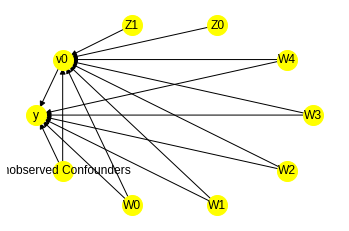

In [33]:
model.view_model()

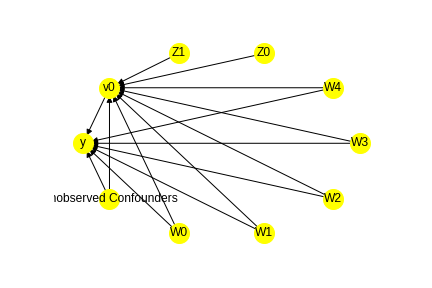

In [34]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done.

In [35]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W0,W1,W4,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W4,W2,U) = P(y|v0,W3,W0,W1,W4,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



## Method 1: Propensity Score Stratification

We will be using propensity scores to stratify units in the data.

In [36]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

/home/sid/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W0,W1,W4,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W4,W2,U) = P(y|v0,W3,W0,W1,W4,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W4+W2
Target units: att

## Estimate
Mean value: 9.953228632880538

Causal Estimate is 9.953228632880538


In [37]:
# Textual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 9.953228632880538 in the expected value of the outcome [y], over the data distribution/population represented by the dataset.


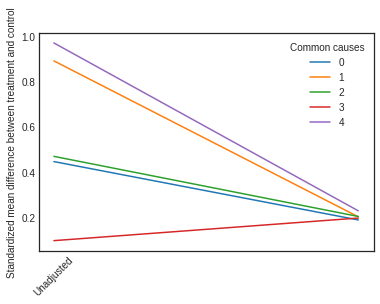

In [38]:
# Visual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="propensity_balance_interpreter")

## Method 2: Propensity Score Matching

We will be using propensity scores to match units in the data.

In [39]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

/home/sid/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W0,W1,W4,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W4,W2,U) = P(y|v0,W3,W0,W1,W4,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W4+W2
Target units: atc

## Estimate
Mean value: 9.29171213374531

Causal Estimate is 9.29171213374531


In [40]:
# Textual Interpreter
interpretation = causal_estimate_match.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 9.29171213374531 in the expected value of the outcome [y], over the data distribution/population represented by the dataset.


Cannot use propensity balance interpretor here since the interpreter method only supports propensity score stratification estimator.